# Проект: RNN. 


In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
import torch
from dataset import TextDataset
from model import LanguageModel
from train import train
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import os
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
# некая "защита"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
# Проверка доступа GPU
if torch.cuda.is_available():
    print("GPU доступен")
    print(f"Текущее устройство: {torch.cuda.current_device()}")
    print(f"Имя устройства: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("GPU недоступен")

GPU доступен
Текущее устройство: 0
Имя устройства: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
# Переносим модель на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
train_set = TextDataset(data_file="C:\\Users\\ksbal\\Desktop\\HW\\dl\\jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="C:\\Users\\ksbal\\Desktop\\HW\\dl\\jokes.txt", train=False, sp_model_prefix="bpe")

In [7]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

In [8]:
len(train_set)

114722

In [9]:
len(valid_set)

6037

Language model 

Я реализую класс LanguageModel на основе RNN или LSTM. Модель будет работать в двух режимах:

Обучение: на вход — последовательности и их длины, на выходе — логиты для следующего токена на каждом шаге;
Генерация: на вход — префикс, далее последовательно семплируются токены до EOS или лимита длины, с обновлением скрытого состояния (без перепрогонки всей последовательности) и применением температуры к логитам перед семплированием.

In [10]:
model = LanguageModel(train_set)

In [11]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Training 

Мне останется реализовать цикл обучения в train.py: учить модель предсказывать следующий токен, обрезать батчи по длине самой длинной последовательности и считать perplexity через лосс в plot_losses.
Я обучу модель с ванильной RNN и сохраню чекпоинт — он пригодится дальше.

In [12]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=True)

In [13]:
#Проверка тк до этого не работало у меня ничего
for batch in train_loader:
    indices, lengths = batch
    print("Indices sample:", indices[0].tolist())
    print("Lengths sample:", lengths[0])
    break

Indices sample: [1, 507, 611, 140, 150, 1305, 1983, 194, 6, 137, 62, 1991, 49, 20, 119, 850, 36, 1977, 505, 273, 28, 777, 590, 389, 95, 86, 107, 1977, 1601, 1977, 49, 199, 1792, 13, 118, 1736, 826, 36, 1975, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Lengths sample: tensor(40)


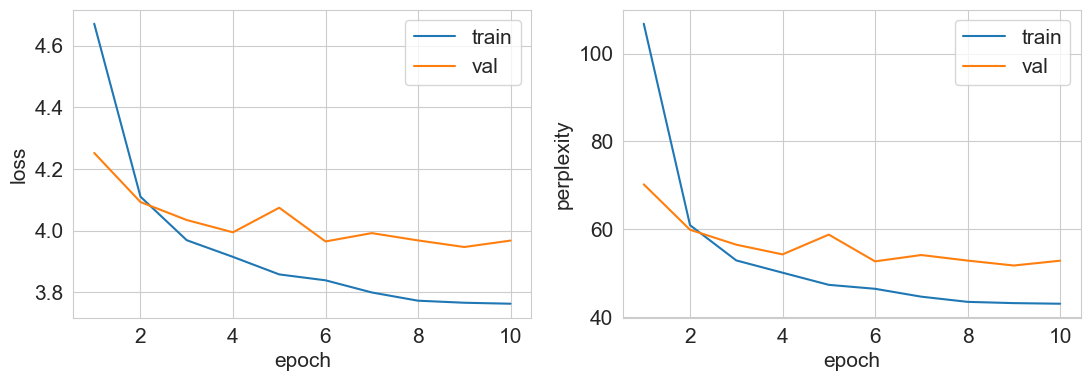

  Validation Loss: 3.9677
  Validation Perplexity: 52.8632
Generation examples:
молоко, в проведу вызывает пакета студенческой паы. чтобы понять не может, то роль - доброе утро.людо-конси- какие, вздыхающие мли... но жить нельзя, есть?унадцать как провести и превоздать тарока!
русский и снег, а машину на шести впечатнили положить на иностранный языком, один раз, она же показывают компенсации и добро в рванечку.
с возрастом обратно в магазин пляш и лете...
взаимочной эвакуации спрашивают- а там какое была офигенство рфлах наука уже предупредить, я намотала она такая сильный, я вне очередь, слегка обращается к окошку. мне прошел успевал громкие где хорошо. тара воспер крикнул но мимо песочницы.
нерабочное переделять надежутся только на актоу зекашей!


In [14]:
# Создаем модель с nn.RNN
model = LanguageModel(
    dataset=train_set,
    embed_size=256,
    hidden_size=512,
    rnn_type=nn.RNN,
    rnn_layers=1
)

model_RNN = model.to(device)
optimizer = optim.Adam(model_RNN.parameters(), lr=1e-3)
train(model_RNN, optimizer, None, train_loader, val_loader, num_epochs=10)

In [15]:
# Сохраняем чекпойнт
torch.save(model.state_dict(), "rnn_language_model.pth")

По метрикам можно сказать, что модель не полностью случайная , но ещё далека от идеала и слова с ошибками

## LSTM 

Обучу аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравню модели по метрикам и генерации.

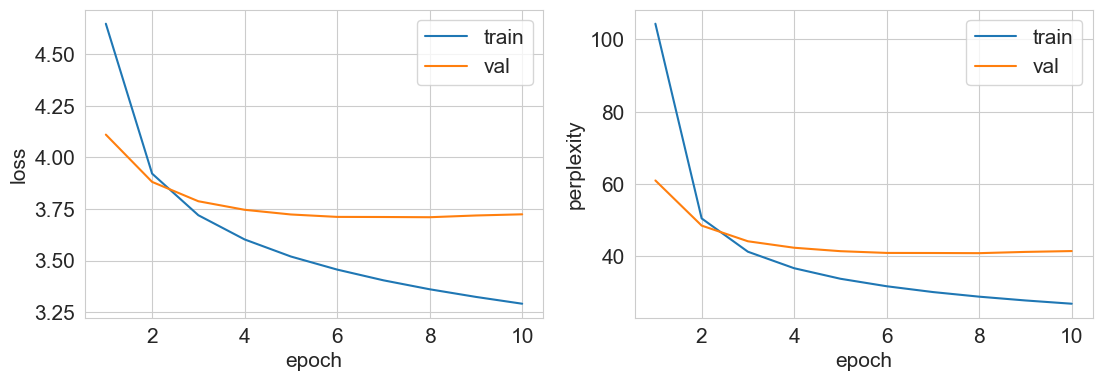

  Validation Loss: 3.7246
  Validation Perplexity: 41.4528
Generation examples:
срочно приехали из рестора козы, а тем не найдут пианино, и тут золотое рыбятник остается картошку, и говорит- бабуля, это разве не?
парень так сильно красива сидит в контрабак по комнате - неправда, но слушает запущено решивши.
объявление на использование планеты девочке нашего такого времени в россии пришлось устаться...
народный серези в коридорожнику валяется сыр. добился сигналажем и хотит жал.
терапевт идет ночью, защитный в патках по песочке, остановился без него и спрашивает- помогите!- почему, доктор?- на кого же ваш вербовый?- ну, и у вас он маленький человек работает?


In [ ]:
# Создаем модель с nn.LSTM
model = LanguageModel(
    dataset=train_set,
    embed_size=256,
    hidden_size=512,
    rnn_type=nn.LSTM, 
    rnn_layers=1
).to(device)

model_LSTM = model.to(device)
optimizer_lstm = optim.Adam(model_LSTM.parameters(), lr=1e-3)
train(model_LSTM, optimizer_lstm, None, train_loader, val_loader, num_epochs=10)

In [17]:
torch.save(model_LSTM.state_dict(), "lstm_language_model.pth")

Модель ведет себя лучше, значение метрик ниже

## Sampling temperature 

Я поэкспериментирую с параметром температуры: запущу генерацию при разных её значениях и с разными префиксами. На основе полученных текстов сделаю выводы о том, как температура влияет на разнообразие, креативность и связность генерируемых последовательностей.

In [19]:
for temp in [0.3, 0.7, 1.0, 1.5]:
    print(f"\n[Температура: {temp}]")
    for prefix in ["Мужик заходит в бар", "Собрались как-то", "Почему шутить можно"]:
        joke = model_RNN.inference(prefix=prefix, temp=temp)
        print("-", joke)


[Температура: 0.3]
- мужик заходит в барс- ну, как вы думаете, что вы мне нравитесь?- да, я не могу, но я же не могу понять, что я не буду, а ты не можешь.
- собрались как-того, не знаю, как ты меня слышишь меня!- да, это я, конечно, не могу!
- почему шутить можно сдать у нас в россии, которые могут быть настроение, которое выдержали на улицу, а там, где ты был на работе.

[Температура: 0.7]
- мужик заходит в бардак- вы не знаете, зачем вы передачи пять джевна, этот фильм ужасов!
- собрались как-това у меня есть нянешь, так себя лапша, а потом еще раз повторять?на что вы говорите, что она не умеет меня разрешается из лестнице!- а почему?- если они не дают нашим материальном, странно.
- почему шутить можно снять тот день, а какой русский не любит.

[Температура: 1.0]
- мужик заходит в барселят- что впервые наступили банка по кличке все равно сравниваются податься за 2 секин-збанка, я охматах новостей - лучшений.
- собрались как-тож скоро надо девать, взорудили пожизненки.тило, татовка 

In [20]:
for temp in [0.3, 0.7, 1.0, 1.5]:
    print(f"\n[Температура: {temp}]")
    for prefix in ["Мужик заходит в бар", "Собрались как-то", "Почему шутить можно"]:
        joke = model_LSTM.inference(prefix=prefix, temp=temp)
        print("-", joke)


[Температура: 0.3]
- мужик заходит в бар. заходит в аптеку и говорит- входите в гости к нам на работу, а в какой-нибудь приезжай?- нет, я не знаю, что вы там недели, а я - нет.
- собрались как-толог на работу. навстречу ему и спрашивают- ну, что, у вас тут же нарушает?- да нет, не могу, я не могу.
- почему шутить можно смотреть на то, чтобы не выбрать, то в зале, что я не могу, а потом - поставить.

[Температура: 0.7]
- мужик заходит в бар, а он меня видит и вырос, говорит только что я не забуду.
- собрались как-тому сидорову, что прислали у него в туалете. студенты- я думал, это все же, как из барабаны.
- почему шутить можно сделать, если не будет.

[Температура: 1.0]
- мужик заходит в бархаблющий- так там наденете 10 собутыльникам...как протозает!
- собрались как-тонику- ты слышал, скажи что бы прикусил заниматься и придумали что-нибудь вместе, но для выпивки нет.стишьем ее не разговаривает.- и что?- философ-бу.- с яйцами по губам?- я, пожалуй, к вам.
- почему шутить можно пить пост

Увеличение температур плохо влияет на генерацию шуток, больше ошибок. LSTM показывает себя лучше (получается что-то более-менее связанное)

## Tokenizers 

Я заменю текущий BPE-токенизатор (с 2000 токенами) на другие варианты: BPE с бо́льшим словарём и пословный (unigram) токенизатор. В качестве рекуррентного слоя возьму тот, что показал лучшее качество ранее. Обучу модели на новых токенизаторах, сохраню чекпоинты и сравню их генерации.

Также я отвечу на вопрос: корректно ли сравнивать такие модели по perplexity, и поясню, почему — с учётом различий в словарях и размерности выходного пространства.

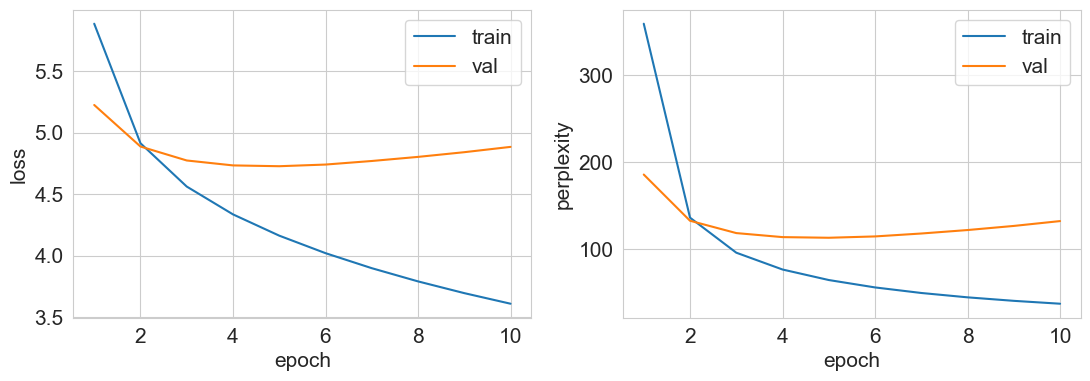

  Validation Loss: 4.8833
  Validation Perplexity: 132.0659
Generation examples:
штирлиц бил убирают в ботинок. утром задумался, вытягивает колбасу из заболек и членом там штирлиц. назовите лишь какой номер телефона русский мужик- ну, вас надо замолчать.
почему на шкаф квну путина наша сборная по футболу - это россия, знаки - фермера? им бей конопли о это отдельные объекты.
парадоксально возмущены почему-нибудь тысяча- цилеки и фактически захваты пластиковой.
российские сериала жена мужа возбуждает от шокзах его любимого человека на перезря ошибку. а потом мски поторав школы к морюреным в гости на телефоней.
софочка, когда первый поливает феем у женщины от собаки. тот приходит женщины и сердце. когда он принес мне из себя,, как вы должны отодиться.


In [21]:
train_set_big = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe_big", vocab_size=10000, model_type='bpe')
valid_set_big = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe_big", vocab_size=10000, model_type='bpe')

train_loader_big = DataLoader(train_set_big, batch_size=64, shuffle=True)
valid_loader_big = DataLoader(valid_set_big, batch_size=64, shuffle=False)

model = LanguageModel(
    dataset=train_set_big,
    embed_size=256,
    hidden_size=512,
    rnn_type=nn.LSTM, 
    rnn_layers=1
).to(device)

model_LSTM_big = model.to(device)
optimizer_lstm = optim.Adam(model_LSTM_big.parameters(), lr=1e-3)
train(model_LSTM_big, optimizer_lstm, None, train_loader_big, valid_loader_big, num_epochs=10)

In [22]:
torch.save(model_LSTM_big.state_dict(), "lstm_bpe_big.pth")

In [23]:
for temp in [0.3, 0.7, 1.0, 1.5]:
    print(f"\n[Температура: {temp}]")
    for prefix in ["Мужик заходит в бар", "Собрались как-то", "Почему шутить можно"]:
        joke = model_LSTM_big.inference(prefix=prefix, temp=temp)
        print("-", joke)


[Температура: 0.3]
- мужик заходит в бартеру, смотрит на него и говорит- ну, как, я вас не понимаю, как вы объясните фюреру?- да, но я не могу понять, что вы, я бы не умер, я бы рад, но не знаю, что вы, не знаете, что у нас в россии.
- собрались как-то шерлок и говорит- у меня сегодня день рождения - это не то, что у меня на даче.- а что, у меня нет денег на голове?
- почему шутить можно считать именами, а негры.

[Температура: 0.7]
- мужик заходит в бартеру. подходит мужчина с собой- ну, как посмеемся, я же не вижу.буратино.- проходите, я был у нас.- извините, вы мне не подскажете, если я выспаться.
- собрались как-томастера и три года- почему на 10 месяцы, так и те, кто критикует за убийство обороны?- можно, но не от кого.
- почему шутить можно считать с помощью электроника, тогда можно объяснить зачем?

[Температура: 1.0]
- мужик заходит в бартерухас и спрашивает- папа, браток с ужасом ниточка?- я сплю!- ну вот, хай! такую же память!- ну-ка, ты ведь где на правачешь?
- собрались ка

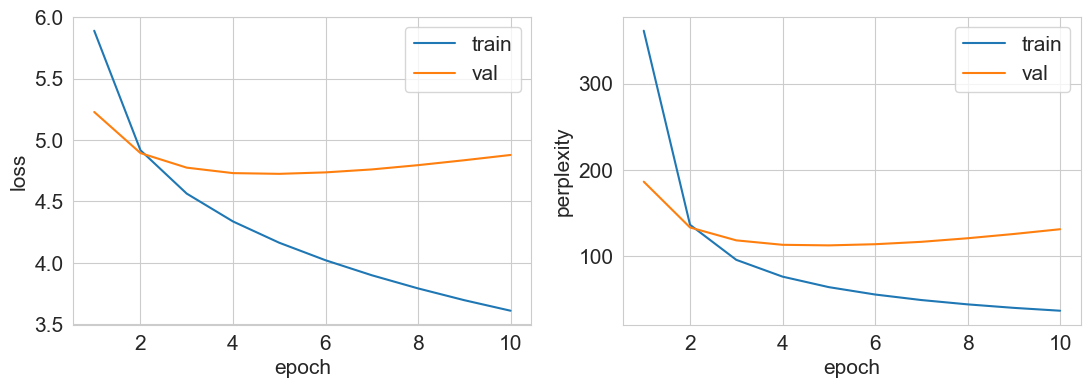

  Validation Loss: 4.8777
  Validation Perplexity: 131.3277
Generation examples:
в джунглях два математика о зарплате студенты запросил небольшую яму на пару секунд. ополландия и скончался права, как тупые этих-а-адеянки, коллиинский голос был более сорокалетних объема в отделении.
водитель маршрутки получика киева- в связи со скайку и скончался в открытый космос!
квеншей крокодилом весь климатский сыт и ручку. постов футболист петровна-парентик. кого у тебя постоянно целовал?- я все в преде занял!
штирлиц, поехали подумал, что увидел хорошего храм на памятнике и в дверь заплалили за компьютерной квартиры патрон и повыше ели. когда он увидел холтофф, то с районным наезде он  ⁇  лет симпот нашел правой рукой.
русский человек с неправильным подозрительным крестным удивлением своего веса ослепна привез - штатам заколеб рассективное и быстро разваливаться каждый террористы.


In [24]:
train_set_unigram = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="unigram", vocab_size=10000, model_type='unigram')
valid_set_unigram = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="unigram", vocab_size=10000, model_type='unigram')

train_loader_unigram = DataLoader(train_set_big, batch_size=64, shuffle=True)
valid_loader_unigram = DataLoader(valid_set_big, batch_size=64, shuffle=False)

model = LanguageModel(
    dataset=train_set_big,
    embed_size=256,
    hidden_size=512,
    rnn_type=nn.LSTM, 
    rnn_layers=1
).to(device)

model_LSTM_unigram = model.to(device)
optimizer_lstm = optim.Adam(model_LSTM_unigram.parameters(), lr=1e-3)
train(model_LSTM_unigram, optimizer_lstm, None, train_loader_unigram, valid_loader_unigram, num_epochs=10)

In [25]:
torch.save(model_LSTM_unigram.state_dict(), "lstm_unigram.pth")

In [26]:
for temp in [0.3, 0.7, 1.0, 1.5]:
    print(f"\n[Температура: {temp}]")
    for prefix in ["Мужик заходит в бар", "Собрались как-то", "Почему шутить можно"]:
        joke = model_LSTM_unigram.inference(prefix=prefix, temp=temp)
        print("-", joke)


[Температура: 0.3]
- мужик заходит в барук, говорит- у меня две новости.- да, я знаю, что я не могу сказать. я просто так себе не видел...
- собрались как-точным и, чтобы не было, но и на всякий случай.
- почему шутить можно, а не доить?

[Температура: 0.7]
- мужик заходит в бар, на приеме у члены- да вы мне не дали леща, но и я скажу вам лопаточку...
- собрались как-то карло. дом-2, а потом в одном месте. вдруг один духовно- на что и не едет?
- почему шутить можно понять, что это такое женский рай, а не для себя?- естественно!

[Температура: 1.0]
- мужик заходит в баруку. избушка- дэбридостражья в шкаф- со своей любимой валерьянки - теперь пусть теперь спят.
- собрались как-то один мужик, отдаетваясь к ловиши-кому-андби.- а что? так, до настроения красоты!- а вы уверены, что его что-то это не смогут сделать оттягивает билеты?!
- почему шутить можно объединить человека перед богом, а сережки - отпустите витаминов?

[Температура: 1.5]
- мужик заходит в бар зашел в еврейскую обращем сно

Обе модели показали очень близкие результаты по метрикам.
Перплексия (Perplexity) для Unigram-модели чуть ниже, но разница незначительна.
Это означает, что обе модели предсказывают следующий токен примерно одинаково хорошо

Latent Semantic Analysis 

Я реализую метрику качества генерации на основе LSA:

* сгенерирую тексты объёмом с валидационную выборку;
* объединю их с декодированной валидацией в один корпус;
* построю TF-IDF матрицу и понижу размерность через TruncatedSVD;
* для каждого сгенерированного текста найду максимальную cosine similarity с валидационными и усредню результат.

Затем я сравню модели с разными токенизаторами по этой метрике и оценю её плюсы (учёт семантики, устойчивость к перефразированию) и минусы (потеря деталей при понижении размерности, зависимость от качества TF-IDF и SVD).

In [50]:
def generate_texts(model, dataset, num_texts=None):
    model.eval()
    generated = []
    num_texts = num_texts or len(dataset)
    for _ in tqdm(range(num_texts)):
        text = model.inference(temp=0.8)
        generated.append(text)
    return generated

In [51]:
gen_vecs_bpe_small = generate_texts(model_LSTM, valid_set)

100%|██████████| 6037/6037 [03:34<00:00, 28.08it/s]


In [52]:
valid_texts = [dataset.ids2text(dataset[i][0].tolist()) for i in range(len(valid_set))]

In [53]:
corpus = valid_texts + gen_vecs_bpe_small

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

In [54]:
svd = TruncatedSVD(n_components=128)  
lsa_matrix = svd.fit_transform(tfidf_matrix)

In [55]:
real_vecs_bpe_small = lsa_matrix[:len(valid_texts)]
gen_vecs_bpe_small = lsa_matrix[len(valid_texts):]

similarites = cosine_similarity(gen_vecs_bpe_small, real_vecs_bpe_small).max(axis=1)
mean_similarity = similarites.mean()

print(f"Среднее максимальное сходство: {mean_similarity:.4f}")

Среднее максимальное сходство: 0.6943


Хорошая семантическая близость, но не точное повторение

In [56]:
gen_vecs_bpe_large = generate_texts(model_LSTM_big, valid_set)
valid_texts = [dataset.ids2text(dataset[i][0].tolist()) for i in range(len(valid_set))]
corpus = valid_texts + gen_vecs_bpe_large

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
svd = TruncatedSVD(n_components=128)  
lsa_matrix = svd.fit_transform(tfidf_matrix)
real_vecs_bpe_large = lsa_matrix[:len(valid_texts)]
gen_vecs_bpe_large = lsa_matrix[len(valid_texts):]

similarites = cosine_similarity(gen_vecs_bpe_large, real_vecs_bpe_large).max(axis=1)
mean_similarity = similarites.mean()

print(f"Среднее максимальное сходство: {mean_similarity:.4f}")

100%|██████████| 6037/6037 [03:28<00:00, 29.02it/s]


Среднее максимальное сходство: 0.6614


In [57]:
gen_vecs_unigram = generate_texts(model_LSTM_unigram, valid_set)
valid_texts = [dataset.ids2text(dataset[i][0].tolist()) for i in range(len(valid_set))]
corpus = valid_texts + gen_vecs_unigram

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
svd = TruncatedSVD(n_components=128)  
lsa_matrix = svd.fit_transform(tfidf_matrix)
real_vecs_unigram = lsa_matrix[:len(valid_texts)]
gen_vecs_unigram = lsa_matrix[len(valid_texts):]

similarites = cosine_similarity(gen_vecs_unigram, real_vecs_unigram).max(axis=1)
mean_similarity = similarites.mean()

print(f"Среднее максимальное сходство: {mean_similarity:.4f}")

100%|██████████| 6037/6037 [03:18<00:00, 30.36it/s]


Среднее максимальное сходство: 0.6865


Лучшая модель: BPE Small\
Она показала наивысшее среднее сходство с валидационной выборкой (0.6943). Это может говорить о том, что:\
1) Модель лучше всего воспроизводит стиль и структуру оригинальных шуток\
2) Несмотря на меньший размер словаря, BPE Small лучше сохраняет смысл при генерации

## Visualization 



In [59]:
def plot_tsne(real_vecs, gen_vecs, title="t-SNE: Real vs Generated texts"):
    all_vecs = np.vstack((real_vecs, gen_vecs))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    vecs_2d = tsne.fit_transform(all_vecs)

    real_2d = vecs_2d[:len(real_vecs)]
    gen_2d = vecs_2d[len(real_vecs):]

    plt.figure(figsize=(8, 6))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], c='blue', label='Real texts', alpha=0.7)
    plt.scatter(gen_2d[:, 0], gen_2d[:, 1], c='red', label='Generated texts', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

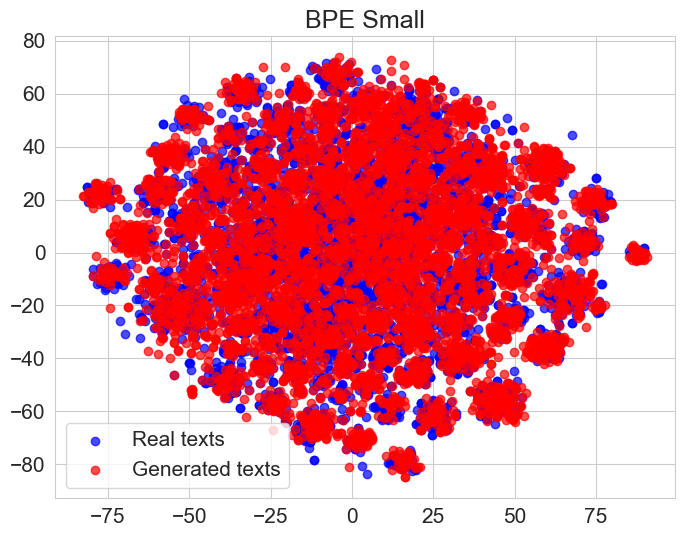

In [60]:
# BPE Small
plot_tsne(real_vecs_bpe_small, gen_vecs_bpe_small, title="BPE Small")

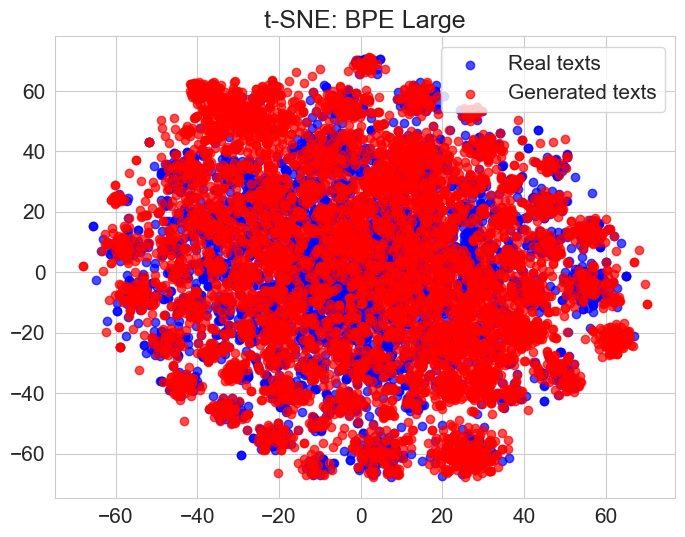

In [61]:
# BPE Large
plot_tsne(real_vecs_bpe_large, gen_vecs_bpe_large, title="t-SNE: BPE Large")

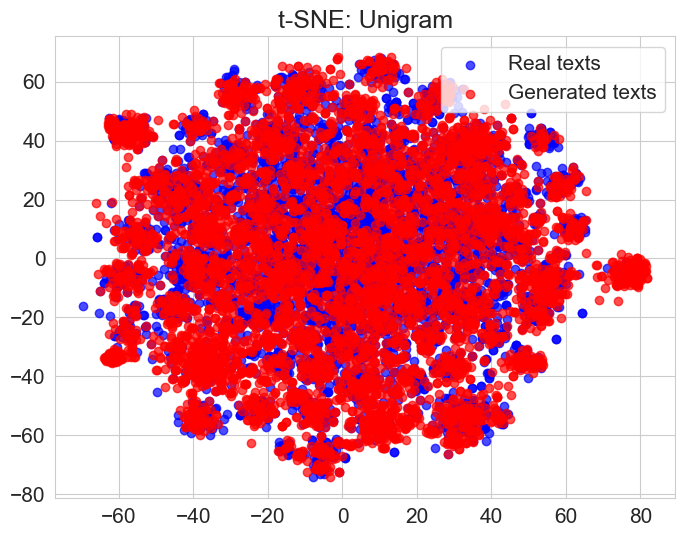

In [62]:
# Для Unigram
plot_tsne(real_vecs_unigram, gen_vecs_unigram, title="t-SNE: Unigram")

## ruGPT perplexity 

Я оценю качество генерации с помощью perplexity, используя предобученную ruGPT3-small из Hugging Face. Сгенерирую синтетические выборки тремя своими моделями и сравню их по perplexity — чем ниже значение, тем ближе генерация к естественному языку.

In [65]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [66]:
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
lm_model = GPT2LMHeadModel.from_pretrained(model_name).to("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

c:\Users\ksbal\Desktop\HW\dl\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ksbal\.cache\huggingface\hub\models--sberbank-ai--rugpt3small_based_on_gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [67]:
def calculate_perplexity(model, tokenizer, texts, device="cuda", max_length=512):
    model.eval()
    encodings = tokenizer("\n\n".join(texts), return_tensors="pt").to(device)

    with torch.no_grad():
        input_ids = encodings.input_ids
        target_ids = input_ids.clone()

        from torch.nn.functional import cross_entropy
        seq_len = input_ids.size(1)
        nlls = []

        for i in range(0, seq_len, max_length):
            begin_loc = i
            end_loc = min(i + max_length, seq_len)
            trg_len = end_loc - begin_loc

            input_batch = input_ids[:, begin_loc:end_loc].to(device)
            target_batch = target_ids[:, begin_loc:end_loc].to(device)

            logits = model(input_batch).logits
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = target_batch[..., 1:].contiguous()

            loss = cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                reduction='none'
            ).view(shift_labels.size())

            nlls.append(loss.mean(dim=-1))

    ppl = torch.exp(torch.cat(nlls).mean())
    return ppl.item()

In [69]:
generated_texts_bpe_small = generate_texts(model_LSTM, valid_set)
generated_texts_bpe_large = generate_texts(model_LSTM_big, valid_set_big)
generated_texts_unigram = generate_texts(model_LSTM_unigram, valid_set_unigram)

100%|██████████| 6037/6037 [03:00<00:00, 33.38it/s]


In [70]:
ppl_bpe_small = calculate_perplexity(lm_model, tokenizer, generated_texts_bpe_small)
print(f"BPE Small PPL: {ppl_bpe_small:.2f}")

ppl_bpe_large = calculate_perplexity(lm_model, tokenizer, generated_texts_bpe_large)
print(f"BPE Large PPL: {ppl_bpe_large:.2f}")

ppl_unigram = calculate_perplexity(lm_model, tokenizer, generated_texts_unigram)
print(f"Unigram PPL: {ppl_unigram:.2f}")

Token indices sequence length is longer than the specified maximum sequence length for this model (164297 > 2048). Running this sequence through the model will result in indexing errors


BPE Small PPL: 228.50
BPE Large PPL: 155.71
Unigram PPL: 187.50


Выиграла модель BPE Large PPL. Она показала наименьшую perplexity, а значит, тексты, которые она генерирует, лучше соответствуют распределению естественного языка , чем у других моделей

Лучшие анекдоты 

In [76]:
joke = model_LSTM_big.inference(prefix='Мужик заходит в бар', temp=0.1)
print(f'Сгенерированный текст: \n {joke}')

Сгенерированный текст: 
 мужик заходит в бартеру, смотрит на него и говорит- ну, как вам сказать, что вы - не бойтесь, это не грех!


In [85]:
joke = model_LSTM_big.inference(prefix='Нет ИИ', temp=0.1)
print(f'Сгенерированный текст: \n {joke}')

Сгенерированный текст: 
 нет иисус, поэтому в этом году на улице потеплело.


In [82]:
joke = model_LSTM_big.inference(prefix='', temp=0.1)
print(f'Сгенерированный текст: \n {joke}')

Сгенерированный текст: 
 в россии на украине показали, что в россии есть нефть и газ, а у нас в россии - это когда у них есть нефть и газ.
